In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import warnings
from tqdm import tqdm
warnings.filterwarnings( 'ignore' )
import glob
import matplotlib.pyplot as plt
import os 
import sys
import time
import seaborn as sns
from sklearn.metrics import roc_curve, auc
import math
import shutil


In [ ]:
data_dir = "/content/drive/MyDrive/USG2_data/train_data"
file_paths = sorted(glob.glob(os.path.join(data_dir, "train_*.npy")))
data_list = [np.load(file_path) for file_path in tqdm(file_paths)]

100%|██████████| 3546/3546 [00:29<00:00, 121.13it/s]


In [ ]:
train_label = pd.read_csv('/content/drive/MyDrive/USG2_data/train_label.csv')
train_label = np.array(train_label)

In [ ]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

rows = 3
cols = 3
n = rows*cols
data = []
# 샘플별로 trace를 생성하여 data에 추가
for i in range(n):
    audio, label = data_list[i],train_label[i]
    trace = dict(x=list(range(len(audio))), y=audio, name=str(label))
    data.append(trace)

# subplot figure 생성
fig = make_subplots(rows=rows, cols=cols, subplot_titles=[str(i) for i in range(n)])

# subplot에 trace 추가
for i in range(n):
    r = i // cols
    c = i % cols
    fig.add_trace(go.Scatter(x=data[i]['x'], y=data[i]['y'], name=data[i]['name']), row=r+1, col=c+1)

# layout 설정
fig.update_layout(title_text="1차원 시계열 plot", height=800, width=800)

# 그래프 출력
fig.show()


Output hidden; open in https://colab.research.google.com to view.

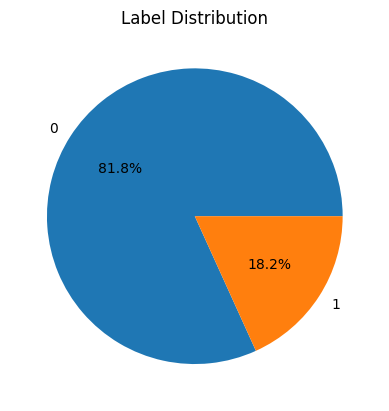

In [ ]:
# train_label.csv 파일 읽어오기
train_label = np.genfromtxt('/content/drive/MyDrive/USG2_data/train_label.csv', delimiter=',', skip_header=1, dtype=np.int)

# label 분포 계산
unique, counts = np.unique(train_label[:, 1], return_counts=True)

# 파이 그래프 그리기
plt.pie(counts, labels=unique, autopct='%1.1f%%')
plt.title('Label Distribution')
plt.show()

# 데이터와 레이블 분리
train_data_0, train_label_0 = zip(*[(data_list[i], label) for i, label in enumerate(train_label[:, 1]) if label == 0])
train_data_1, train_label_1 = zip(*[(data_list[i], label) for i, label in enumerate(train_label[:, 1]) if label == 1])


In [ ]:
result = []
for i in tqdm(range(len(train_data_0))):  
  window_size = 10000
  overlap_size = 3000
  data = train_data_0[i]
  
  start = 0
  while start + window_size <= len(data):
      window = data[start:start+window_size]
      result.append(window)
      start += window_size - overlap_size
    
print(len(result)) 
resultof0 = np.array(result)

100%|██████████| 2900/2900 [00:00<00:00, 55397.59it/s]


31900


In [ ]:
result = []
for i in tqdm(range(len(train_data_1))): 
  window_size = 10000
  overlap_size =8560
  data = train_data_1[i]
  
  start = 0
  while start + window_size <= len(data):
      window = data[start:start+window_size]
      result.append(window)
      start += window_size - overlap_size
resultof1 = np.array(result)
print(len(resultof1))

100%|██████████| 646/646 [00:00<00:00, 13053.97it/s]


31654


In [ ]:
label_0  = np.zeros(31900)
label_1 = np.ones(31654)

In [ ]:
train_1 = tf.data.Dataset.from_tensor_slices((resultof1 ,label_1))
train_0 = tf.data.Dataset.from_tensor_slices((resultof0, label_0))

In [ ]:
(31900+31654)//32

1986

In [ ]:
batch_size = 32
Dataset = train_0.concatenate(train_1).shuffle(buffer_size =31900+31654+100, seed = 55).batch(batch_size).prefetch(1)

In [ ]:
Valid_Dataset = Dataset.take(486 * batch_size) 
Train_Dataset = Dataset.skip(486 * batch_size)
Train_Dataset = Dataset.take(1500 * batch_size)

In [ ]:
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.7, patience=2
),
tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=10
)]

In [ ]:
model35 = keras.models.Sequential([ 
        keras.layers.InputLayer(input_shape=(10000,1)),
        keras.layers.Conv1D(64, 512, strides =128),
        keras.layers.BatchNormalization(),
        keras.layers.Conv1D(128, 4, strides = 2,padding = 'same'),
        keras.layers.BatchNormalization(),
        keras.layers.Activation('elu'),
        keras.layers.MaxPool1D(pool_size = 2),
        keras.layers.GRU(256),
        keras.layers.Dense(units = 64, activation = 'elu', kernel_initializer = 'he_normal'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(units = 16, activation = 'elu', kernel_initializer = 'he_normal'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(units = 1, activation = 'sigmoid'),
])
model35.summary()
model35.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 75, 64)            32832     
                                                                 
 batch_normalization (BatchN  (None, 75, 64)           256       
 ormalization)                                                   
                                                                 
 conv1d_1 (Conv1D)           (None, 38, 128)           32896     
                                                                 
 batch_normalization_1 (Batc  (None, 38, 128)          512       
 hNormalization)                                                 
                                                                 
 activation (Activation)     (None, 38, 128)           0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 19, 128)          0

In [ ]:
hist1 = model35.fit(Train_Dataset, epochs = 50, shuffle = True, validation_data = Valid_Dataset, callbacks = callbacks)

Epoch 1/50
1987/1987 [==============================] - 48s 16ms/step - loss: 0.2850 - accuracy: 0.8827 - val_loss: 0.1343 - val_accuracy: 0.9518 - lr: 0.0010
Epoch 2/50
1987/1987 [==============================] - 30s 15ms/step - loss: 0.1548 - accuracy: 0.9489 - val_loss: 0.1021 - val_accuracy: 0.9644 - lr: 0.0010
Epoch 3/50
1987/1987 [==============================] - 26s 13ms/step - loss: 0.1105 - accuracy: 0.9653 - val_loss: 0.0589 - val_accuracy: 0.9807 - lr: 0.0010
Epoch 4/50
1987/1987 [==============================] - 26s 13ms/step - loss: 0.0849 - accuracy: 0.9737 - val_loss: 0.0472 - val_accuracy: 0.9850 - lr: 0.0010
Epoch 5/50
1987/1987 [==============================] - 26s 13ms/step - loss: 0.0713 - accuracy: 0.9785 - val_loss: 0.0389 - val_accuracy: 0.9871 - lr: 0.0010
Epoch 6/50
1987/1987 [==============================] - 25s 13ms/step - loss: 0.0579 - accuracy: 0.9822 - val_loss: 0.0379 - val_accuracy: 0.9854 - lr: 0.0010
Epoch 7/50
1987/1987 [========================

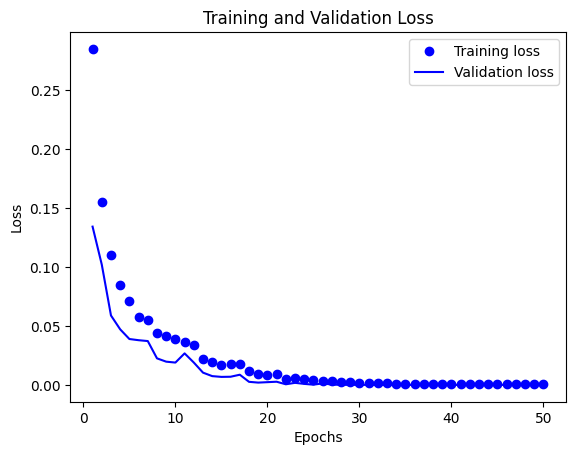

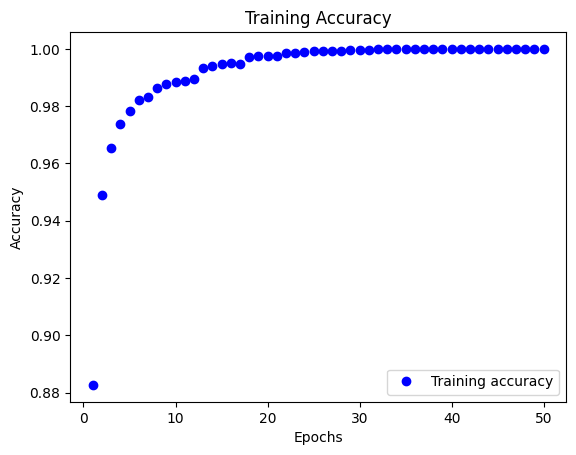

In [ ]:
train_loss = hist1.history['loss']
val_loss = hist1.history['val_loss']
accuracy = hist1.history['accuracy']

# epoch 수 만큼의 숫자 배열을 생성
epochs = range(1, len(train_loss) + 1)

# Loss 그래프 출력
plt.plot(epochs, train_loss, 'bo', label='Training loss') # 파란색 점
plt.plot(epochs, val_loss, 'b', label='Validation loss') # 파란색 실선
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Accuracy 그래프 출력
plt.plot(epochs, accuracy, 'bo', label='Training accuracy') # 파란색 점
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
model35.save_weights("/content/drive/MyDrive/USG2_data/CNN_RNN.h5")

In [ ]:
model35.load_weights("/content/drive/MyDrive/USG2_data/CNN_RNN.h5")

In [ ]:
test_dir = "/content/drive/MyDrive/USG2_data/test_data"
file_paths = sorted(glob.glob(os.path.join(test_dir, "test_*.npy")))
test_list = [np.load(file_path) for file_path in tqdm(file_paths)]

100%|██████████| 1115/1115 [00:24<00:00, 45.00it/s] 


In [ ]:
test_window_size = 10000
test_overlap_size = 0
test_windows = []
for test_data in tqdm(test_list):
    test_data_windows = [test_data[i:i+test_window_size] for i in range(0, len(test_data)-test_window_size+1, test_window_size-test_overlap_size)]
    test_windows.extend(test_data_windows)

test_data_array = np.array(test_windows)
print(len(test_data_array))


100%|██████████| 1115/1115 [00:00<00:00, 186603.18it/s]


8920


In [ ]:
print(len(test_data_array))

8920


In [ ]:
empty_label = None
Test_Set = tf.data.Dataset.from_tensor_slices((test_data_array,empty_label))
Test_Set = Test_Set.batch(32)
y_pred = model35.predict(Test_Set)

279/279 [==============================] - 3s 6ms/step


In [ ]:
pred_list = []
for i in range(len(test_list)):
  prediction = y_pred[8*i] + y_pred[8*i + 1] + y_pred[8*i + 2] + y_pred[8*i + 3] + y_pred[8*i + 4] + y_pred[8*i + 5] + y_pred[8*i + 6] + y_pred[8*i + 7] 
  pred_list.append(prediction)
last = np.array(pred_list)/8.0

In [ ]:
th = 0.61
test_label = (last >= th).astype(int)

unique, counts = np.unique(test_label, return_counts=True)

# Create pie chart
fig = go.Figure(data=[go.Pie(labels=unique, values=counts, hole=.3)])

# Update layout
fig.update_layout(title='Label Distribution')

# Show plot
fig.show()


In [ ]:
sub = pd.read_csv("/content/drive/My Drive/USG2_data/answer_sample.csv")
sub.iloc[:,1] = test_label
sub.to_csv('/content/drive/My Drive/USG2_data/61.csv',index = False)

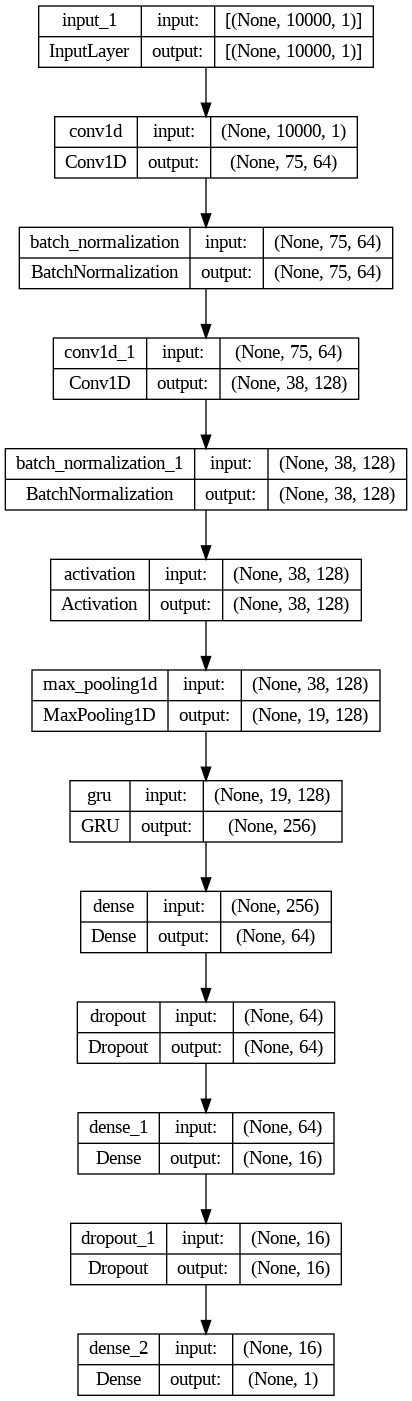

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model35, to_file='model_shapes.png', show_shapes=True)